# LSTM Model Test

Long short-term memory is a recurrent neural network used to model sequential data. For this specific use, we wanted a model that would be able to analyze patterns and trends for a given stock data.

In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


from tensorflow.keras import models
from tensorflow.keras.layers import LSTM,Dense

In [385]:
df_prices = pd.read_csv('./data/prices-split-adjusted.csv')
df_prices.fillna(float(0))
df_prices['date'] = pd.to_datetime(df_prices['date'])

df_prices = df_prices[df_prices['symbol']=='XOM']
df_prices = df_prices.drop(columns=['symbol'])
df_dates = df_prices['date'].copy()
df_prices = df_prices.set_index('date')

df = df_prices['close'].to_frame()

df.head()

,close
date,
2010-01-04,69.150002
2010-01-05,69.419998
2010-01-06,70.019997
2010-01-07,69.800003
2010-01-08,69.519997


In [386]:
def prep_data(df, scaler, split):
    df = scaler.fit_transform(np.array(df).reshape(-1,1))
    size = int(len(df)*split)

    train_data = df[0:size,:]
    test_data = df[size:,:]
    
    return train_data, test_data

def fix_data(data, scaler):
    return scaler.inverse_transform(np.array(data).reshape(-1,1))

def build_data(data, step):
    x, y = [], []
    
    for i in range(len(data)-step-1):
        x.append(data[i:(i+step),0])
        y.append(data[i+step,0])
        
    return np.array(x), np.array(y)


def build_model(optimizer, step):
    model = models.Sequential()

    model.add(LSTM(64,return_sequences=True,input_shape=(step,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(32,return_sequences=True))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    model.summary()
    
    return model

In [387]:
split = 0.7
step = 60

standard = StandardScaler()
min_max = sklearn.preprocessing.MinMaxScaler()

scaler = min_max

train_data, test_data = prep_data(df, scaler, split)

X_train, y_train = build_data(train_data, step)
X_test, y_test = build_data(test_data, step)

print("X Training Shape: "+str(X_train.shape))
print("X Test Shape: "+str(X_test.shape))
print("Y Training Shape: "+str(y_train.shape))
print("Y Test Shape: "+str(y_test.shape))

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X Training Shape: (1172, 60)
X Test Shape: (468, 60)
Y Training Shape: (1172,)
Y Test Shape: (468,)


In [388]:
model = build_model('adam',step)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 60, 64)            16896     
_________________________________________________________________
lstm_37 (LSTM)               (None, 60, 50)            23000     
_________________________________________________________________
lstm_38 (LSTM)               (None, 60, 32)            10624     
_________________________________________________________________
lstm_39 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 67,171
Trainable params: 67,171
Non-trainable params: 0
_________________________________________________________________


In [389]:
model.fit(X_train,y_train,epochs=40,batch_size=32)

y_hat = model.predict(X_test)

error = np.sqrt(mean_squared_error(y_test,y_hat))

y_test = fix_data(y_test, scaler)
y_hat = fix_data(y_hat, scaler)

error

Epoch 1/40
37/37 [==============================] - 3s 83ms/step - loss: 0.0409
Epoch 2/40
37/37 [==============================] - 3s 78ms/step - loss: 0.0046
Epoch 3/40
37/37 [==============================] - 3s 75ms/step - loss: 0.0038
Epoch 4/40
37/37 [==============================] - 3s 76ms/step - loss: 0.0039
Epoch 5/40
37/37 [==============================] - 3s 78ms/step - loss: 0.0035
Epoch 6/40
37/37 [==============================] - 3s 77ms/step - loss: 0.0035
Epoch 7/40
37/37 [==============================] - 3s 80ms/step - loss: 0.0032
Epoch 8/40
37/37 [==============================] - 3s 78ms/step - loss: 0.0029
Epoch 9/40
37/37 [==============================] - 3s 81ms/step - loss: 0.0029
Epoch 10/40
37/37 [==============================] - 3s 83ms/step - loss: 0.0026
Epoch 11/40
37/37 [==============================] - 3s 83ms/step - loss: 0.0027
Epoch 12/40
37/37 [==============================] - 3s 78ms/step - loss: 0.0023
Epoch 13/40
37/37 [==================

0.028440066058303046

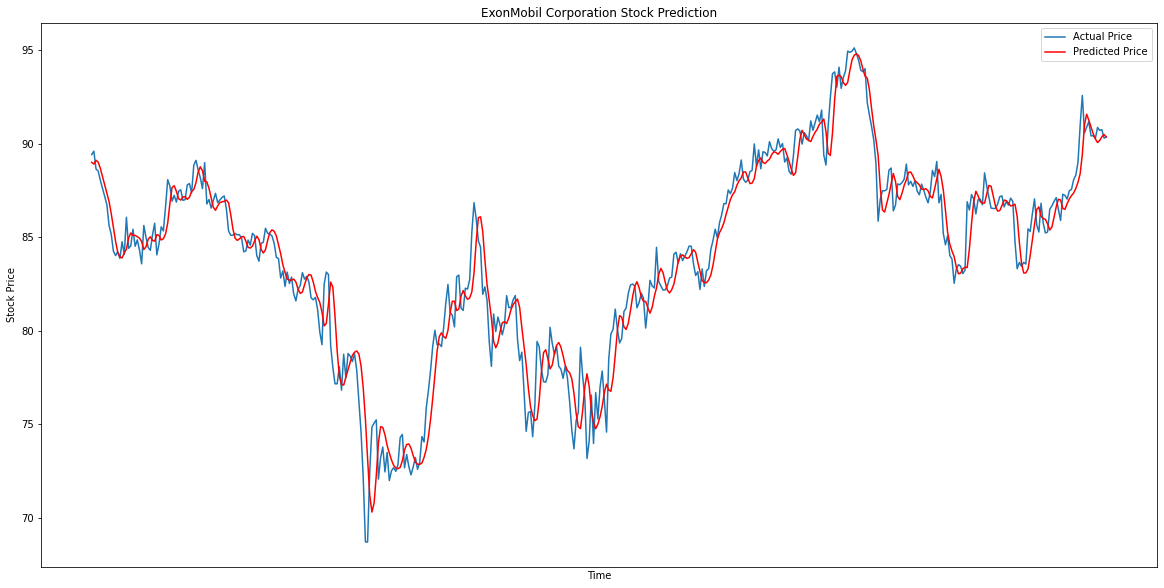

In [390]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax.plot(y_test,label='Actual Price')
ax.plot(y_hat, c='r', label='Predicted Price')
ax.set_title('ExonMobil Corporation Stock Prediction')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Time')
ax.tick_params(axis='x',
               which='both',
               bottom=False,
               top=False,
               labelbottom=False)
ax.legend()

In [439]:
def get_forecast(data, model, scaler, history):
    prediction_list = data[-history:]
    data, empty = prep_data(prediction_list, scaler, 1)
    x, y = build_data(data, 10)
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    forecast = model.predict(x)
    return forecast


history = int(len(y_test)/5)

forecast = get_forecast(data, model, scaler, history)
forecast = fix_data(forecast,scaler)
forecast = np.concatenate((y_test,forecast))
graph_df = pd.DataFrame(forecast)

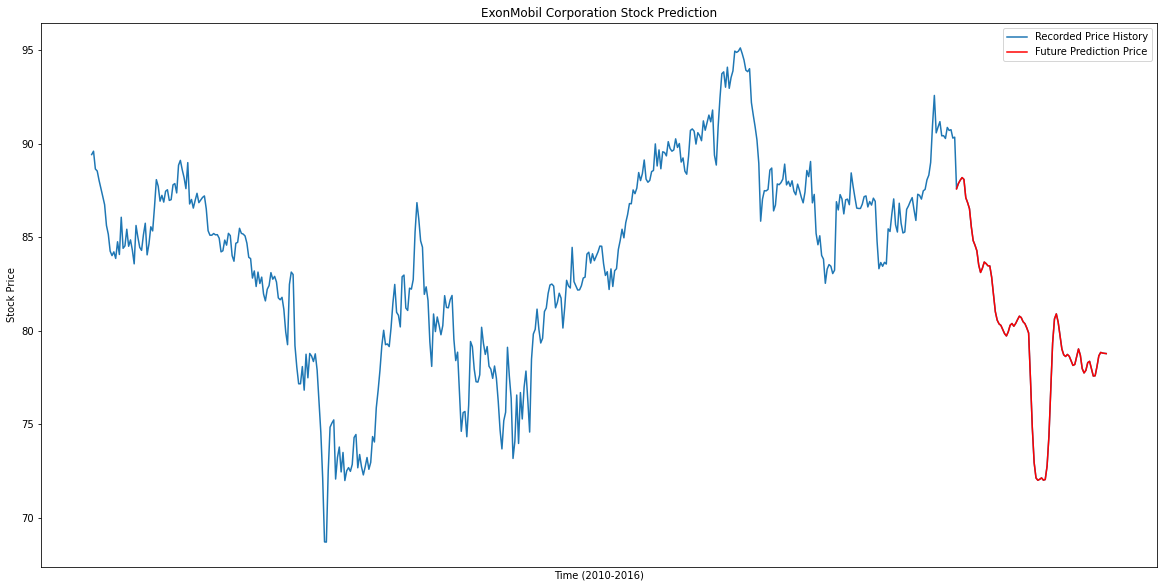

In [441]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))

ax.plot(graph_df, label='Recorded Price History')
ax.plot(graph_df.loc[graph_df.index >= len(y_test)], c='r',label='Future Prediction Price')

ax.set_title('ExonMobil Corporation Stock Prediction')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Time (2010-2016)')
ax.tick_params(axis='x',
               which='both',
               bottom=False,
               top=False,
               labelbottom=False)
ax.legend()